In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport ocfeats


In [41]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from utils import read_trc, read_mot
import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'

def get_trc_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'
    

In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72


In [4]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')


p060


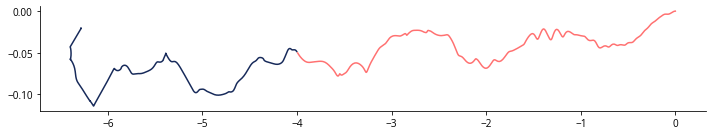

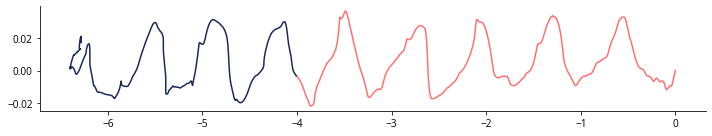

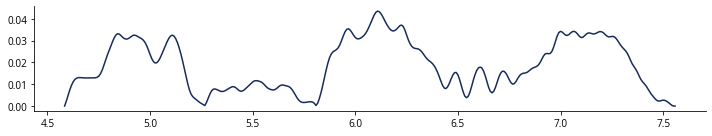

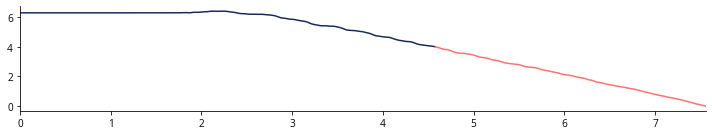

In [6]:
from numpy.linalg import norm

# pid = 'p014'
pid = 'p060'
# pid = 'p093'

df_temp = df_trial[df_trial.trial_clean == '10mwt']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
com = xyz[:,np.argmax(markers == 'midHip'),:] # TODO uses actual CoM
com -= com[-1,:]

com_dist = norm(com[:,[0,2]], axis=-1)
last_4m = np.argmax(com_dist < 4)
time_4m = (xyz.shape[0] - last_4m)/fps
time_10m = time_4m * 10 / 4
speed = 4 / time_4m

com_bob = com[last_4m:,1].ptp()

com_xz = com[last_4m:,[0,2]].copy()
direction = com_xz[0,:] - com_xz[-1,:]
direction /= norm(direction)
com_xz -= np.outer(com_xz @ direction, direction)
com_sway = norm(com_xz, axis=1).ptp()

plt.figure(figsize=(10,2))
plt.plot(com[:last_4m,2], com[:last_4m,0])
plt.plot(com[last_4m:,2], com[last_4m:,0])
plt.tight_layout()
plt.show()
               
plt.figure(figsize=(10,2))
plt.plot(com[:last_4m,2], com[:last_4m,1])
plt.plot(com[last_4m:,2], com[last_4m:,1])
plt.tight_layout()
plt.show()

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t[last_4m:], norm(com_xz, axis=1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,2))
plt.plot(t[:last_4m], com_dist[:last_4m])
plt.plot(t[last_4m:], com_dist[last_4m:])
plt.xlim(t[0], t[-1])
plt.tight_layout()
plt.show()


In [7]:
df_temp = df_trial[df_trial.trial_clean == '10mwt']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    # print(pid)
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))        
    com = xyz[:,np.argmax(markers == 'midHip'),:] # TODO uses actual CoM
    com -= com[-1,:]
    
    com_dist = norm(com[:,[0,2]], axis=-1)
    last_4m = np.argmax(com_dist < 4)
    time_4m = (xyz.shape[0] - last_4m)/fps
    time_10m = time_4m * 10 / 4
    speed = 4 / time_4m

    com_bob = com[last_4m:,1].ptp()

    com_xz = com[last_4m:,[0,2]].copy()
    direction = com_xz[0,:] - com_xz[-1,:]
    direction /= norm(direction)
    com_xz -= np.outer(com_xz @ direction, direction)
    com_sway = norm(com_xz, axis=1).ptp()
        
    data.append({'pid': pid,
                 'speed': speed,
                 'time_10m': time_10m,
                 'com_bob': com_bob,
                 'com_sway': com_sway,
                })


  0%|          | 0/87 [00:00<?, ?it/s]

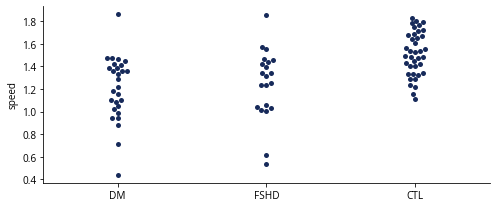

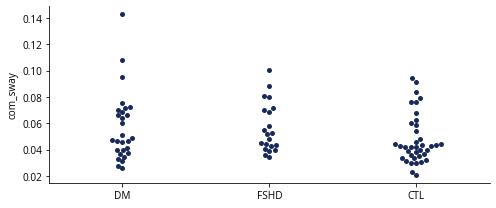

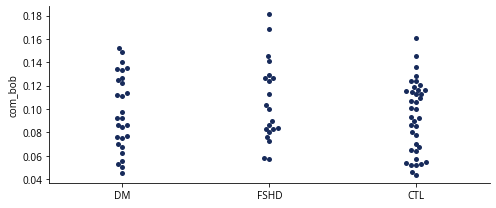

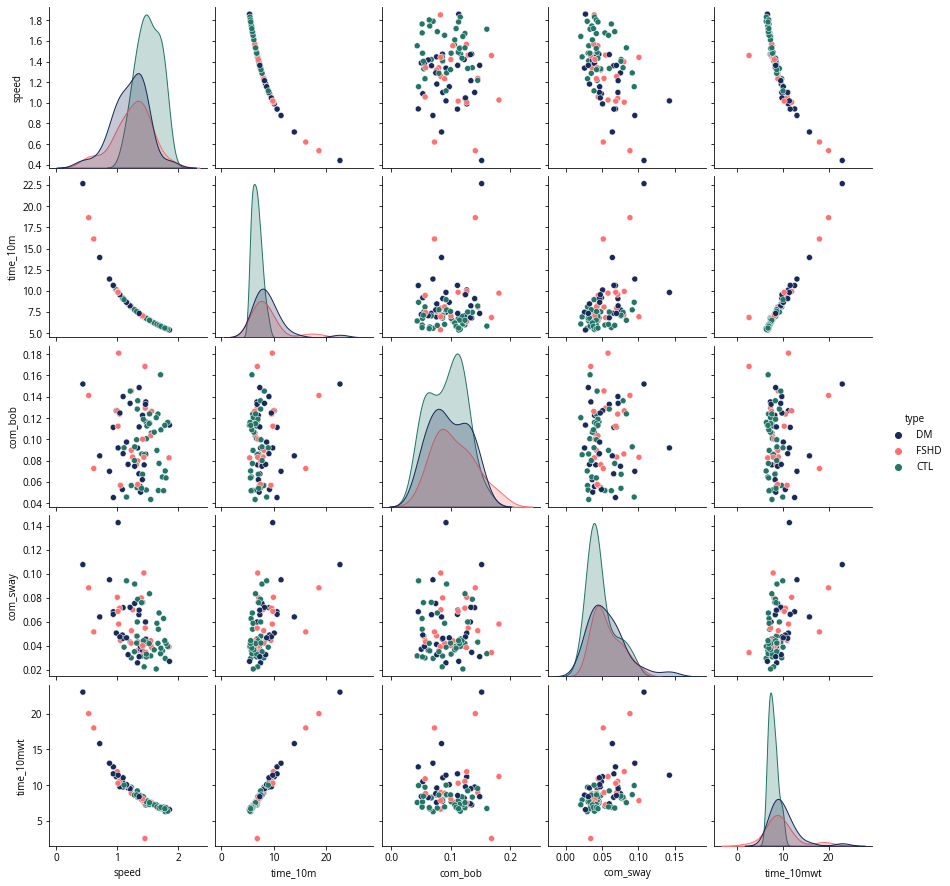

In [9]:
df_10mwt = pd.DataFrame(data)
df_temp = df_10mwt.merge(df_part[['pid', 'time_10mwt', 'type']],
                          on='pid', how='left')

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='speed')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='com_sway')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='com_bob')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()


sns.pairplot(df_temp, hue='type')
plt.show()


In [10]:
df_temp = df_trial[df_trial.trial_clean == '10mwrt']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    # print(pid)
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))        
    com = xyz[:,np.argmax(markers == 'midHip'),:] # TODO uses actual CoM
    com -= com[-1,:]
    
    com_dist = norm(com[:,[0,2]], axis=-1)
    last_4m = np.argmax(com_dist < 4)
    time_4m = (xyz.shape[0] - last_4m)/fps
    time_10m = time_4m * 10 / 4
    speed = 4 / time_4m

    com_bob = com[last_4m:,1].ptp()

    com_xz = com[last_4m:,[0,2]].copy()
    direction = com_xz[0,:] - com_xz[-1,:]
    direction /= norm(direction)
    com_xz -= np.outer(com_xz @ direction, direction)
    com_sway = norm(com_xz, axis=1).ptp()
        
    data.append({'pid': pid,
                 'speed': speed,
                 'time_10m': time_10m,
                 'com_bob': com_bob,
                 'com_sway': com_sway,
                })


  0%|          | 0/86 [00:00<?, ?it/s]

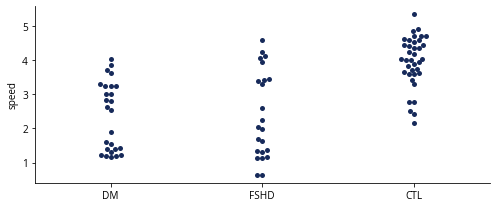

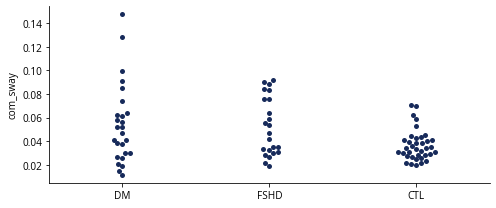

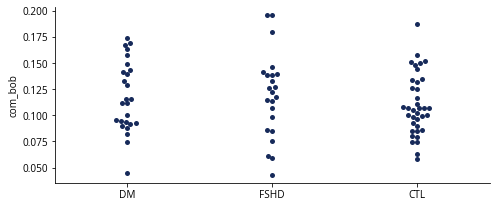

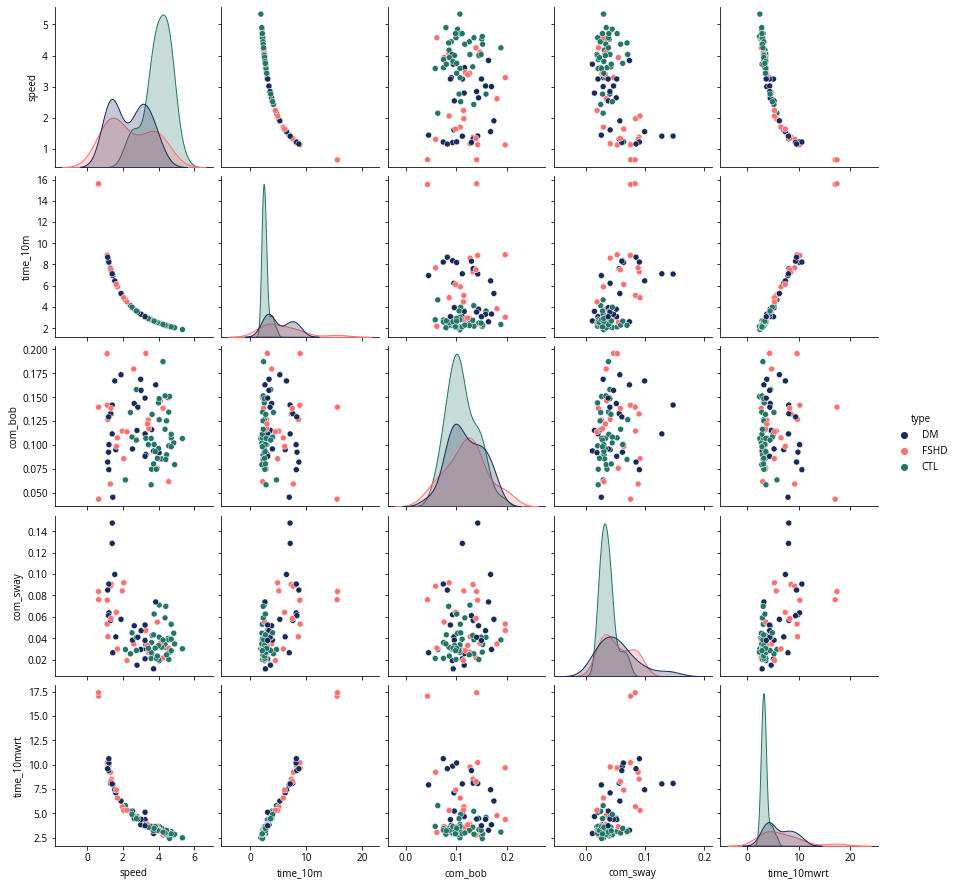

In [11]:
df_10mwrt = pd.DataFrame(data)
df_temp = df_10mwrt.merge(df_part[['pid', 'time_10mwrt', 'type']],
                          on='pid', how='left')

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='speed')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='com_sway')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='com_bob')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

sns.pairplot(df_temp, hue='type')
plt.show()


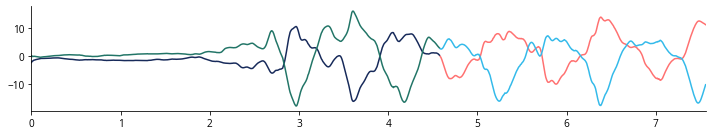

((908,), (908, 3))

In [28]:
# pid = 'p014'
pid = 'p060'
# pid = 'p093'
# pid = 'p026'

df_temp = df_trial[df_trial.trial_clean == '10mwt']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
last_4m = ocfeats.gait_trc_feats(xyz, markers, fps)[-1]

df = read_mot(get_mot_fpath(sid, trial))

rha = df.hip_adduction_r.to_numpy()
lha = df.hip_adduction_l.to_numpy()

ptp_r_hip_add = rha.ptp()
ptp_l_hip_add = lha.ptp()

t = df.time.to_numpy()
plt.figure(figsize=(10,2))
plt.plot(t[:last_4m], rha[:last_4m])
plt.plot(t[last_4m:], rha[last_4m:])
plt.plot(t[:last_4m], lha[:last_4m])
plt.plot(t[last_4m:], lha[last_4m:])
plt.xlim(t[0], t[-1])
plt.tight_layout()
plt.show()

t.shape, com.shape

In [37]:
df.columns

Index(['time', 'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
       'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
       'elbow_flex_r', 'pro_sup_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
       'elbow_flex_l', 'pro_sup_l'],
      dtype='object')

In [38]:
df_temp = df_trial[df_trial.trial_clean == '10mwrt']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    # print(pid)

    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    last_4m = ocfeats.gait_trc_feats(xyz, markers, fps)[-1]

    df = read_mot(get_mot_fpath(sid, trial))

    rha = df.hip_adduction_r.to_numpy()
    lha = df.hip_adduction_l.to_numpy()
    rka = df.knee_angle_r.to_numpy()
    lka = df.knee_angle_l.to_numpy()

    ptp_r_hip_add = rha.ptp()
    ptp_l_hip_add = lha.ptp()
    mean_ptp_hip_add = (ptp_r_hip_add + ptp_l_hip_add) / 2
    
    max_rka = rka.max()
    max_lka = lka.max()
    mean_max_ka = (max_rka + max_lka) / 2
        
    data.append({'pid': pid,
                 'mean_ptp_hip_add': mean_ptp_hip_add,
                 'mean_max_ka': mean_max_ka,
                })


  0%|          | 0/86 [00:00<?, ?it/s]

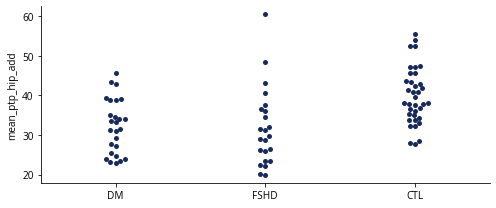

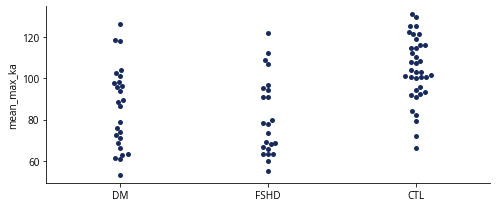

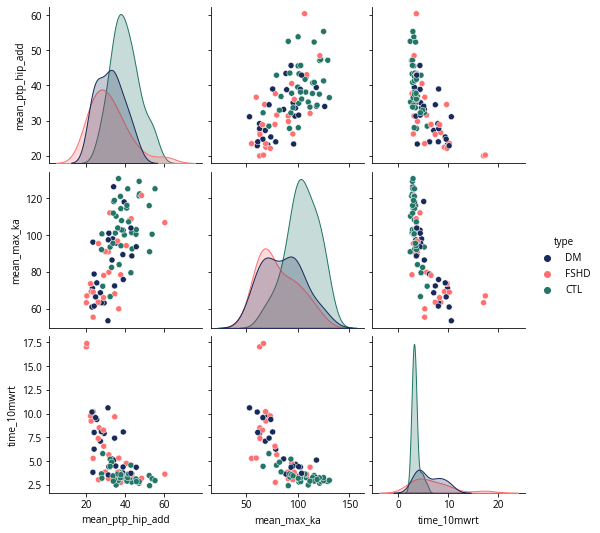

In [40]:
df_10mwrt = pd.DataFrame(data)
df_temp = df_10mwrt.merge(df_part[['pid', 'time_10mwrt', 'type']],
                          on='pid', how='left')

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='mean_ptp_hip_add')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.swarmplot(df_temp, x='type', y='mean_max_ka')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

sns.pairplot(df_temp, hue='type')
plt.show()
